# Data Processing

### Graphs:
- 1. Mass vs time
- 2. 
- 3. 
- 4. 

### subtasks:
- Integrate previous name consolidations

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load data file into pandas dataframe

In [2]:
# path to 3d-printing data CSV file
csv_file = 'data/3d_curr.csv'

# Use pandas to read the CSV file into a DataFrame
df = pd.read_csv(csv_file)

# convert timestamp column from str to pd.Timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Now we can work with the 'df' DataFrame to analyze or manipulate the data as needed
print(df.head())  # Print the first few rows of the DataFrame

            timestamp          name   print_time print_mass_grams  \
0 2021-11-29 19:37:03    karen hinh         8h30               90   
1 2021-11-29 19:37:24    karen hinh           4h               40   
2 2021-11-29 21:37:33     Chr Allum   8ish hours    too damn much   
3 2021-11-29 22:32:55    Sam Kaplan      2 hr 54              36g   
4 2021-11-29 22:33:49  Avery Clowes  8hrs 30 min              53g   

        reason_print class printer  
0  Project Team/Club   NaN     NaN  
1      Class Project   PIE     NaN  
2      Class Project   DFM     NaN  
3   Personal Project   NaN     NaN  
4      Class Project   PIE     NaN  


## print mass vs time

/var/folders/fs/7xnvl2f16v918p54xgw1kxjm0000gn/T/ipykernel_26724/935543833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_print_mass["print_mass_grams"] = df_print_mass["print_mass_grams"].str.replace(r'\D', '', regex=True).replace('', np.nan)


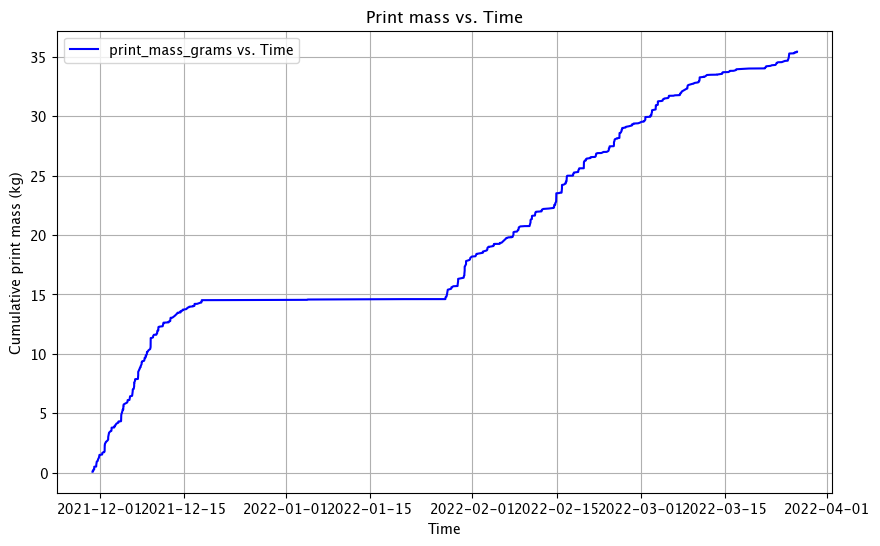

In [3]:
# create new dataframe with copies of timestamp and print_mass_grams columns
df_print_mass = df[["timestamp", "print_mass_grams"]]

# clean all non-numeric characters from print_mass col and replace empty strings with nan
df_print_mass["print_mass_grams"] = df_print_mass["print_mass_grams"].str.replace(r'\D', '', regex=True).replace('', np.nan)
df_print_mass = df_print_mass[df_print_mass["print_mass_grams"].notnull()] # remove any colums with nan print mass
df_print_mass["print_mass_grams"] = df_print_mass["print_mass_grams"].astype(float)

# add column for cumulative sum of print masses
df_print_mass["print_mass_cum"] = df_print_mass["print_mass_grams"].cumsum()

# Create a line plot using Matplotlib
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plt.plot(df_print_mass['timestamp'], df_print_mass["print_mass_cum"].div(1000), linestyle='-', color='b', label='print_mass_grams vs. Time')
plt.title("Print mass vs. Time")
plt.xlabel('Time')
plt.ylabel("Cumulative print mass (kg)")
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

## Deal with class names (uhH)

In [7]:
# # Standardize each class to ensure pie/principles of integrated engineering are the same/pieeeeeee are the same
# df_both <-
#   df_both %>% 
#   mutate (
#     class = str_replace(class, "Desnat|desnT|DesNat|dednat|Des Nat|ddesnat|desnat|desNat|Design Nature", "DesNat"),
#     class = str_replace(class, "passion.*", "Pass. Pursuit"),
#     class = str_replace(class, "pie.*", "PIE"),
#     class = str_replace(class, "dfm|.*manufact.*", "DFM"),
#     class = str_replace(class, ".*scope.*", "Scope"),
#     class = str_replace(class, ".*indep.*|is.*", "IS"),
#     class = str_replace(class, ".*renewable.*", "Ren. Energy"),
#     class = str_replace(class, ".*eec.*", "EEC"),
#     class = str_replace(class, ".*proto.*", "Mech Proto"),
#     class = str_replace(class, ".*qea.*", "QEA"),
#     class = str_replace(class, ".*research.*|.*lair.*", "Research"),
#     class = str_replace(class, ".*market.*|p&.*|p[[:space:]]&.*", "P&M"),
#     class = str_replace(class, ".*sust.*", "SustDes"),
#     class = str_replace(class, ".*robos.*", "RoboSys"),
#     class = str_replace(class, ".*dbf.*|design[[:space:]]bu.*", "DBF"),
#     class = ifelse(reason_print == "Personal Project", replace_na(class, "Personal Proj."), class),
#     class = ifelse(reason_print == "Test Piece", replace_na(class, "Test Piece"), class),
#     class = ifelse(reason_print == "Project Team/Club", replace_na(class, "Proj. Team/Club"), class),
#     class = ifelse(reason_print == "Class Project", replace_na(class, "Class/Research Unspec"), class),  	
#     reason_print = ifelse(str_detect(reason_print, "Class Project"), "Class Project/Research", reason_print),
    
#    # class = ifelse(reason_print == "Class Project/Research" & is.na(class), "Class/Research Unspec", class),
#    # class = ifelse(reason_print == "Project Team/Club" & is.na(class), "Proj. Team/Club", class),
#     class = factor(
#       class,
#       levels = c("Pass. Pursuit", "PIE", "DFM", "Scope", "IS", "DesNat", "Ren. Energy", "EEC", "Mech Proto", "QEA", "Research", "P&M", "SustDes", "RoboSys", "DBF", "Personal Proj.", "Test Piece", "Proj. Team/Club", "Class/Research Unspec")
#     )

names = df["name"]

print(names.unique())

# unique_names_dirty = df["class"].unique()
# print(unique_names_dirty, len(unique_names_dirty))

['karen hinh' 'Chr Allum' 'Sam Kaplan' 'Avery Clowes' 'sam kapaln' 'alex'
 'Alex' 'sam kaplan' 'Audrey Abraham' 'Tigey Jewell-Alibhai' 'Aaron Huang'
 'Becca Suchowerr' 'Becca Suchower' 'Ishaan Oberoi' 'Moises Sabido Garcia'
 'Rowan Jansens' 'Jong Ho Lee' 'David tarazi' 'Chris Alllum' 'Annie Tor'
 'Ethan Cheen' 'Chris Allum' 'Elias w' 'Owen Dray' 'Luke Milroy'
 'Anmol Rattan Singh Sandhu' 'Yehya Albakri' 'Chris Sanchez' 'Rajiv'
 'Jul Hunt' 'Grant' 'Rajv' nan 'Rohil Agarwal' 'ChrChris Allum' 'Linda'
 'Chris Alum' 'Madeline Robertson' 'Austin Cline' 'Ivonne Munoz'
 'Allison Li' 'Nia Maywar' 'Arnav' 'Arla' 'Han' 'Julia Hunt' 'Jay'
 'Sophie Wu' 'Jen Siegel' 'Ellie' 'Tigey Jewel-Alibhai' 'joseh gilbeert'
 'Dia' 'Sinope' 'Drew Pang' 'Andrew C' 'Nabih' 'simon' 'Brooke Moss'
 'Laurel Rodriguez Mitton' 'Rishita Sarin' 'Io' 'Sam Mendelson'
 'josephgilbert' 'Emma Fox' 'jjoseph gilbewrt' 'rowan jansens'
 'joseph gilbert' 'Lily Jiang' 'rajiv' 'Satchel' 'allison li' 'Brent Usui'
 'Mateo Macias' "Chri

## Deal with student names (uuuhhhHHH)